In [1]:
# %pip install opencv-python
# %pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def filter_hough_lines(lines, min_length=300, angle_threshold=10):
    verticals = []
    horizontals = []
    for x1, y1, x2, y2 in lines[:, 0]:
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length < min_length:
            continue
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if abs(angle) < angle_threshold or abs(angle - 180) < angle_threshold:
            horizontals.append((x1, y1, x2, y2))
        elif abs(angle - 90) < angle_threshold or abs(angle + 90) < angle_threshold:
            verticals.append((x1, y1, x2, y2))
    return verticals, horizontals


In [3]:
def autocorp_nonblack(img, threshold=1, shrink=0.1):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to get a mask
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    coords = cv2.findNonZero(mask)
    
    if coords is None:
        return img
    
    x, y, w, h = cv2.boundingRect(coords)
    
    # shrinkg image
    shrink_w = int(w * shrink)
    shrink_h = int(h * shrink)
    
    x_new = x + shrink_w
    y_new = y + shrink_h
    w_new = w - 2 * shrink_w
    h_new = h - 2 * shrink_h

    return img[y_new:y_new+h_new, x_new:x_new+w_new]

In [4]:
def detect_board_and_warp(image, output_size=(800, 800)):
    # Load and resize image (optional)
    img = (image)
    # img = cv2.resize(img, (1000, 1000))  # scale for consistency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plot grayscaled image
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3) # the parameters are: 
                                                     # Lowthreshold(which is the lower bound for the hysteresis thresholding), 
                                                     # Highthreshold(which is the upper bound for the hysteresis thresholding), 
                                                     # and apertureSize(which is the size of the Sobel kernel used to compute the gradient).
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=100, minLineLength=70, maxLineGap=15)
    
    debug_lines = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(debug_lines, (x1, y1), (x2, y2), (255, 0, 0), 5)
            
    # Approximate outer rectangle from Hough lines (very naive)
    # We assume that the outermost lines (bounding the board) are the longest horizontal/vertical
    verticals = []
    horizontals = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < 20:  # vertical line
            verticals.append(line[0])
        elif abs(y1 - y2) < 20:  # horizontal line
            horizontals.append(line[0])
            
    top = min(horizontals, key=lambda l: l[1])
    bottom = max(horizontals, key=lambda l: l[1])
    left = min(verticals, key=lambda l: l[0])
    right = max(verticals, key=lambda l: l[0])
    
    src_pts = np.array([
        [left[0], top[1]],
        [right[2], top[1]],
        [right[2], bottom[3]],
        [left[0], bottom[3]]
    ], dtype='float32')

    dst_pts = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype='float32')

    # Perspective warp
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, matrix, output_size)

    return img, debug_lines, warped

In [5]:
def split_board_into_cells(warped_img, grid_X_size=16, padding=0):
    cell_height = warped_img.shape[0] // grid_X_size
    cell_width = warped_img.shape[1] // grid_X_size
    
    cells = {}
    for i in range(grid_X_size):
        for j in range(grid_X_size):
            x1 = j * cell_width
            y1 = i * cell_height
            x2 = (j + 1) * cell_width
            y2 = (i + 1) * cell_height
            
            pad_x = int(padding * cell_width)
            pad_y = int(padding * cell_height)
            
            x1 = max(0, x1 - pad_x)
            y1 = max(0, y1 - pad_y)
            x2 = min(warped_img.shape[1], x2 + pad_x)
            y2 = min(warped_img.shape[0], y2 + pad_y)
            
            # TODO: Assign the cells to the defined class inside board.py
            cell_img = warped_img[y1:y2, x1:x2]
            label = f"{chr(65 + i)}{j + 1}"  # e.g., A1, B1, ..., P16
            cells[label] = cell_img
            
    return cells

In [ ]:
def extract_board_by_contour(image_path, output_size=(800, 800), debug=False):
    warped = None
    image = cv2.imread(image_path)
    orig = image.copy()
    img_area = image.shape[0] * image.shape[1]
    
    # Convert to grayscale and blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, d=11, sigmaColor=17, sigmaSpace=17)

    # Canny edge detection
    edged = cv2.Canny(gray, 1, 10, apertureSize=3)
    edged = cv2.dilate(edged, None, iterations=1)
    
    #show edged image
    plt.imshow(edged, cmap='gray')
    plt.axis('off')

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:4]
    
    #show contours
    debug_img = image.copy()
    for i, contour in enumerate(contours):
        cv2.drawContours(debug_img, [contour], -1, (0, 255, 0), 3)  # Draw each contour in green

    # Plot the image with the contours
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{4} Largest Contours")
    plt.axis("off")
    plt.show()

    board_contour = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 0.1 * img_area:  # skip tiny contours
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            # Check if it's rectangular-ish
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.8 < aspect_ratio < 1.2:  # roughly square/rectangular
                board_contour = approx
                break

    if board_contour is None:
        raise RuntimeError("Could not find a valid board contour.")
    
    # Draw the detected contour
    debug_img = cv2.drawContours(orig.copy(), [board_contour], -1, (0,255,0), 5)
    plt.subplot(1,2,2)
    plt.title("Detected Contour")
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.show()

    # Order points
    def order_points(pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    rect = order_points(board_contour)
    dst = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype="float32")

    # Warp the image
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(orig, M, output_size)

    return warped


In [246]:
import re

input_img = 'train/3_15.jpg'
template_img = ["train/1_00.jpg", "train/2_00.jpg", "train/3_00.jpg", "train/4_00.jpg", "train/5_00.jpg"]  # your perfect board image
query_img = input_img              # skewed image

match = re.search(r'/(?P<number>\d+)_', input_img) # THIS MIGHT HAVE TO BE REMOVED WHEN PROJECT FINISHED AND SENT FOR EVALUATION}
img_num = 0
if match:
    img_num = match.group('number')
    #set to int
    img_num = int(img_num)

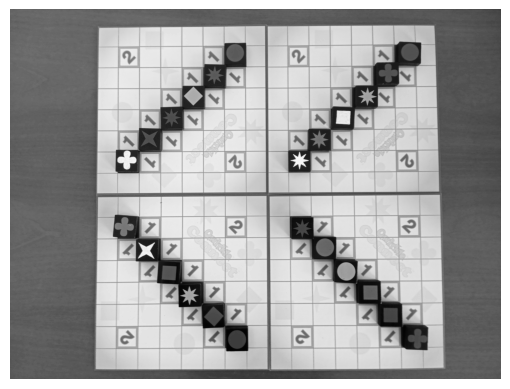

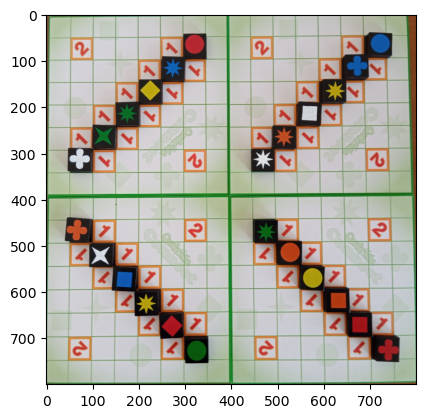

In [247]:
# warp template_img and show result
warped_template = cv2.imread(template_img[img_num-1])
_, debug_lines, warped_template = detect_board_and_warp(warped_template, output_size=(800, 800))
plt.imshow(cv2.cvtColor(warped_template, cv2.COLOR_BGR2RGB))

# save warped template img
cv2.imwrite(f"warped_template.jpg", warped_template)
wrp_tmp_path = f"warped_template.jpg"

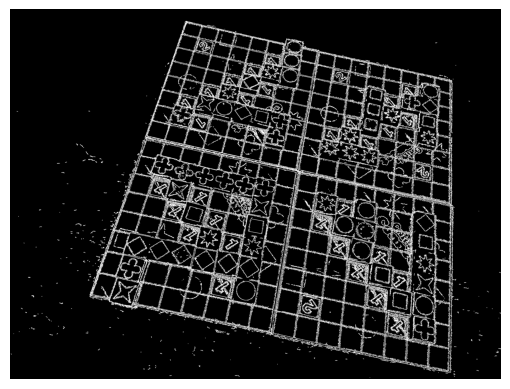

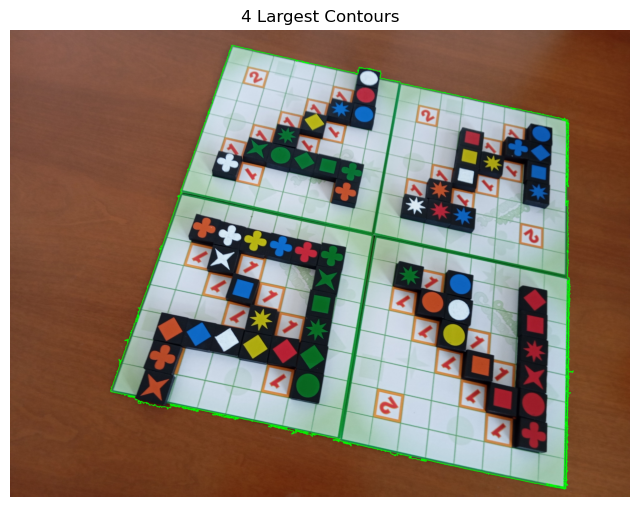

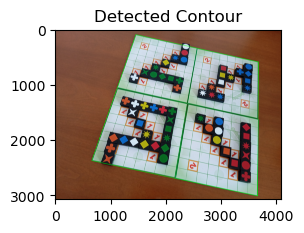

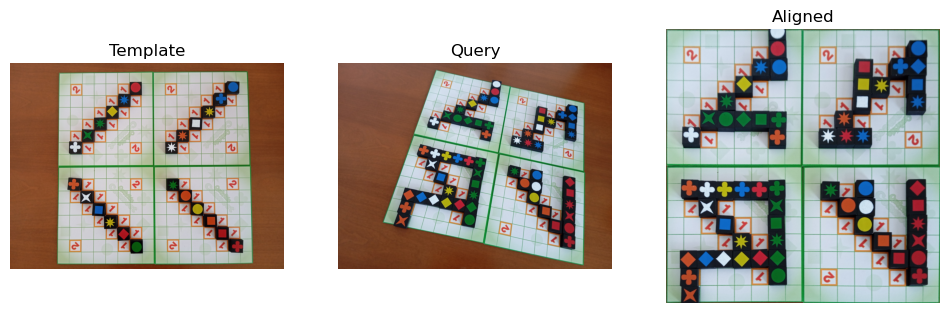

In [248]:
from imgAlignment import align_board

# input_img = 'board+tiles/tiles_3.jpg'
# template_img = ['board+tiles/tiles_3.jpg']
# query_img = 'board+tiles/tiles_3.jpg'

# tpl, qry, aligned_img, image_matches = align_board(wrp_tmp_path, query_img, output_size=(800,800), show_details=False , use_sift=False, homography_threshold=0.75)

aligned_img = extract_board_by_contour(query_img, output_size=(800, 800), debug=True)
# warped = extract_qwirkle_subboards(input_img, debug=True)

#show image matches
# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))
# plt.axis("off")

# aligned_img = autocorp_nonblack(aligned_img, threshold=0.5, shrink=0)

plt.figure(figsize=(12,4))
# Read template and query images
template_img_array = cv2.imread(template_img[img_num - 1])  # Read the template image
if template_img_array is None:
    raise FileNotFoundError(f"Template image not found at path: {template_img[img_num - 1]}")

query_img_array = cv2.imread(query_img)  # Read the query image
if query_img_array is None:
    raise FileNotFoundError(f"Query image not found at path: {query_img}")

for i, img in enumerate([template_img_array, query_img_array, aligned_img], 1):
    plt.subplot(1, 3, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(["Template", "Query", "Aligned"][i - 1])
plt.show()

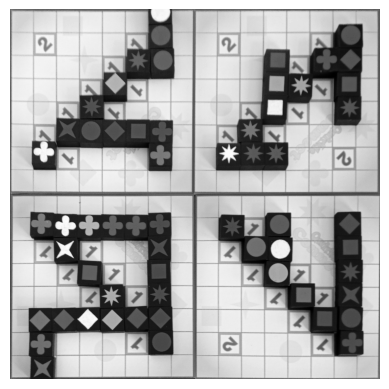

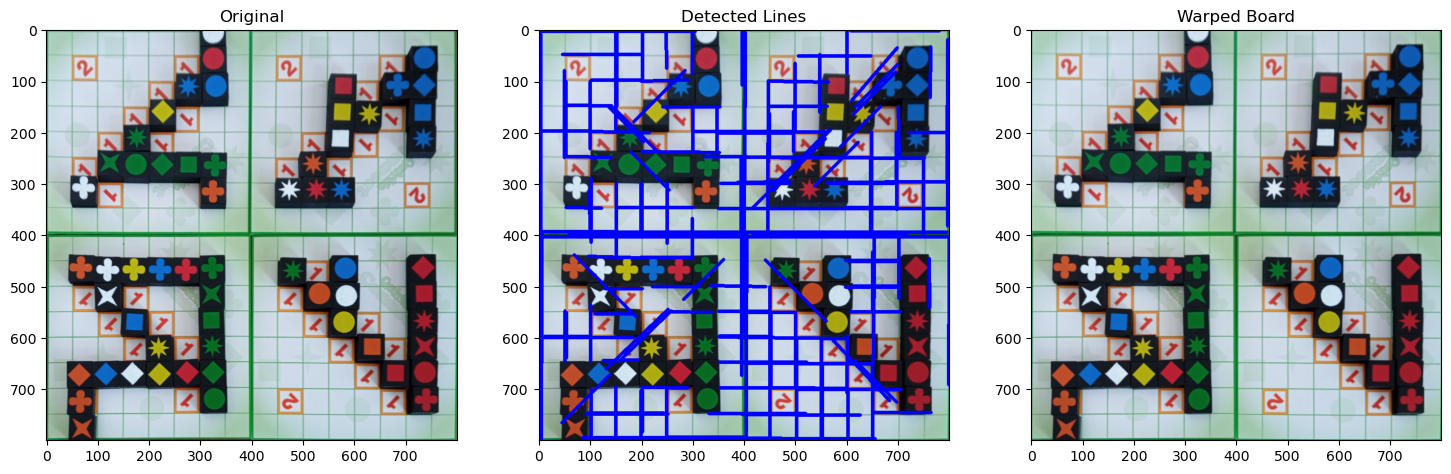

In [249]:
original, lines, warped = detect_board_and_warp(aligned_img)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(lines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

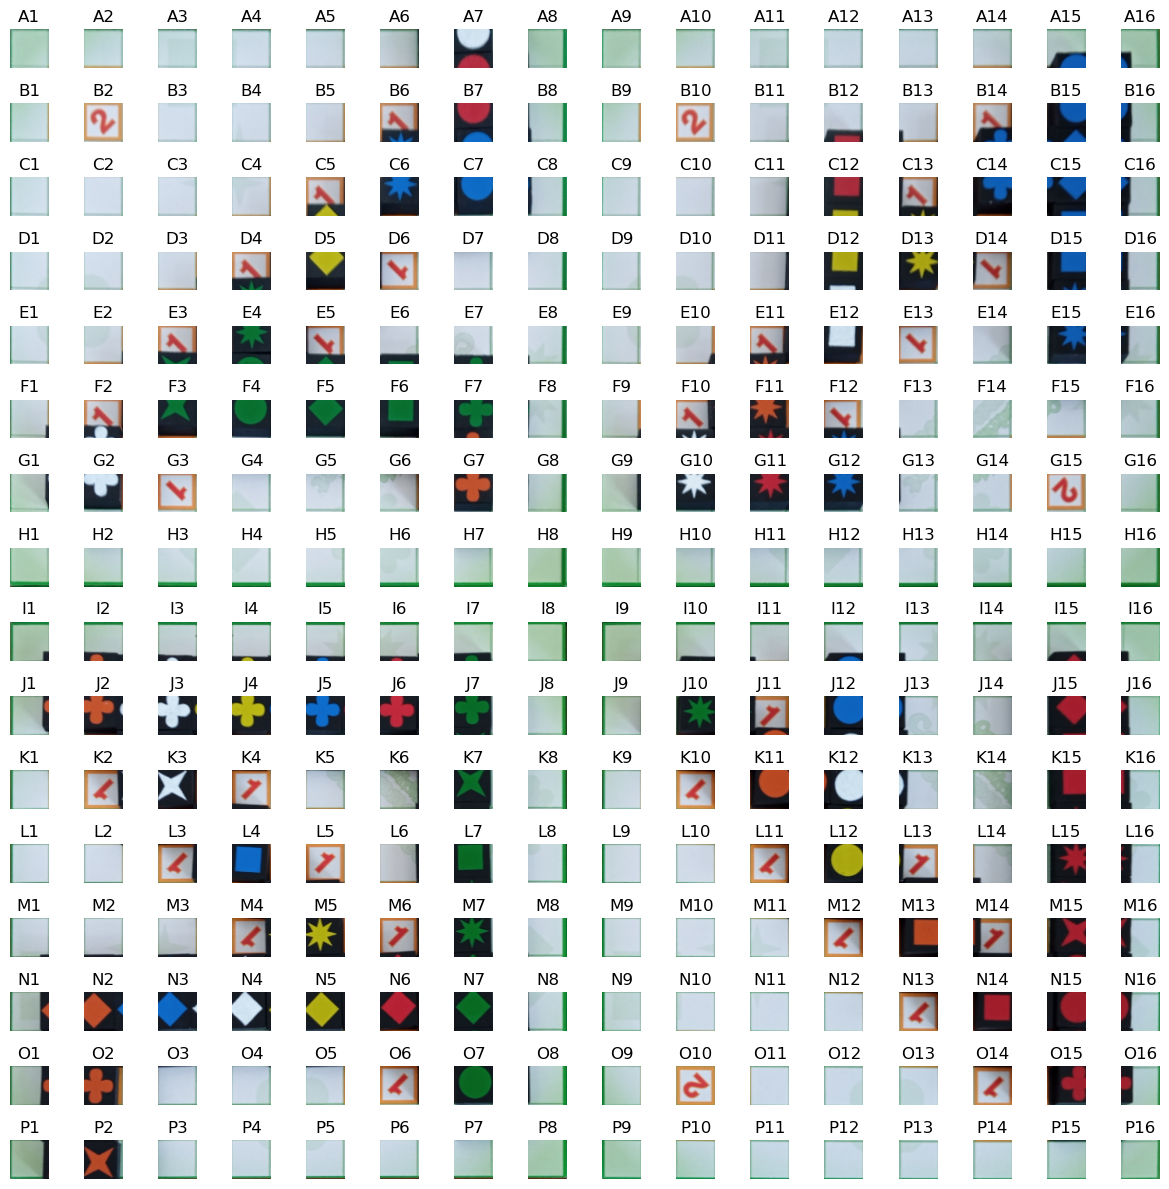

In [253]:
from board import Board

detection_grid = split_board_into_cells(warped, 16, padding=-0.1)
cells_grid = split_board_into_cells(warped, 16, padding=0)

board = Board()
# for label in cells_grid.keys():
    # board.add_cell(label, cells_grid[label])

plt.figure(figsize=(12, 12))
for i, (label, cell_img) in enumerate(list(cells_grid.items()), 1):
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()



In [254]:
from tileDetection import is_tile_present

tiles = []
tiles_present = []

for label, cell_img in cells_grid.items():
    # Check if a tile is present in the current cell
    is_present = is_tile_present(detection_grid.get(label), threshold=64, min_foreground_ratio=0.28)
    
    # Add the tile information to the tiles list
    tiles.append({'label': label, 'isPresent': is_present, 'img': cell_img})
    
    # If a tile is present, add it to the tiles_present list
    if is_present:
        tiles_present.append({'label': label, 'isPresent': is_present, 'img': cell_img, 'detection_img': detection_grid.get(label)})
    

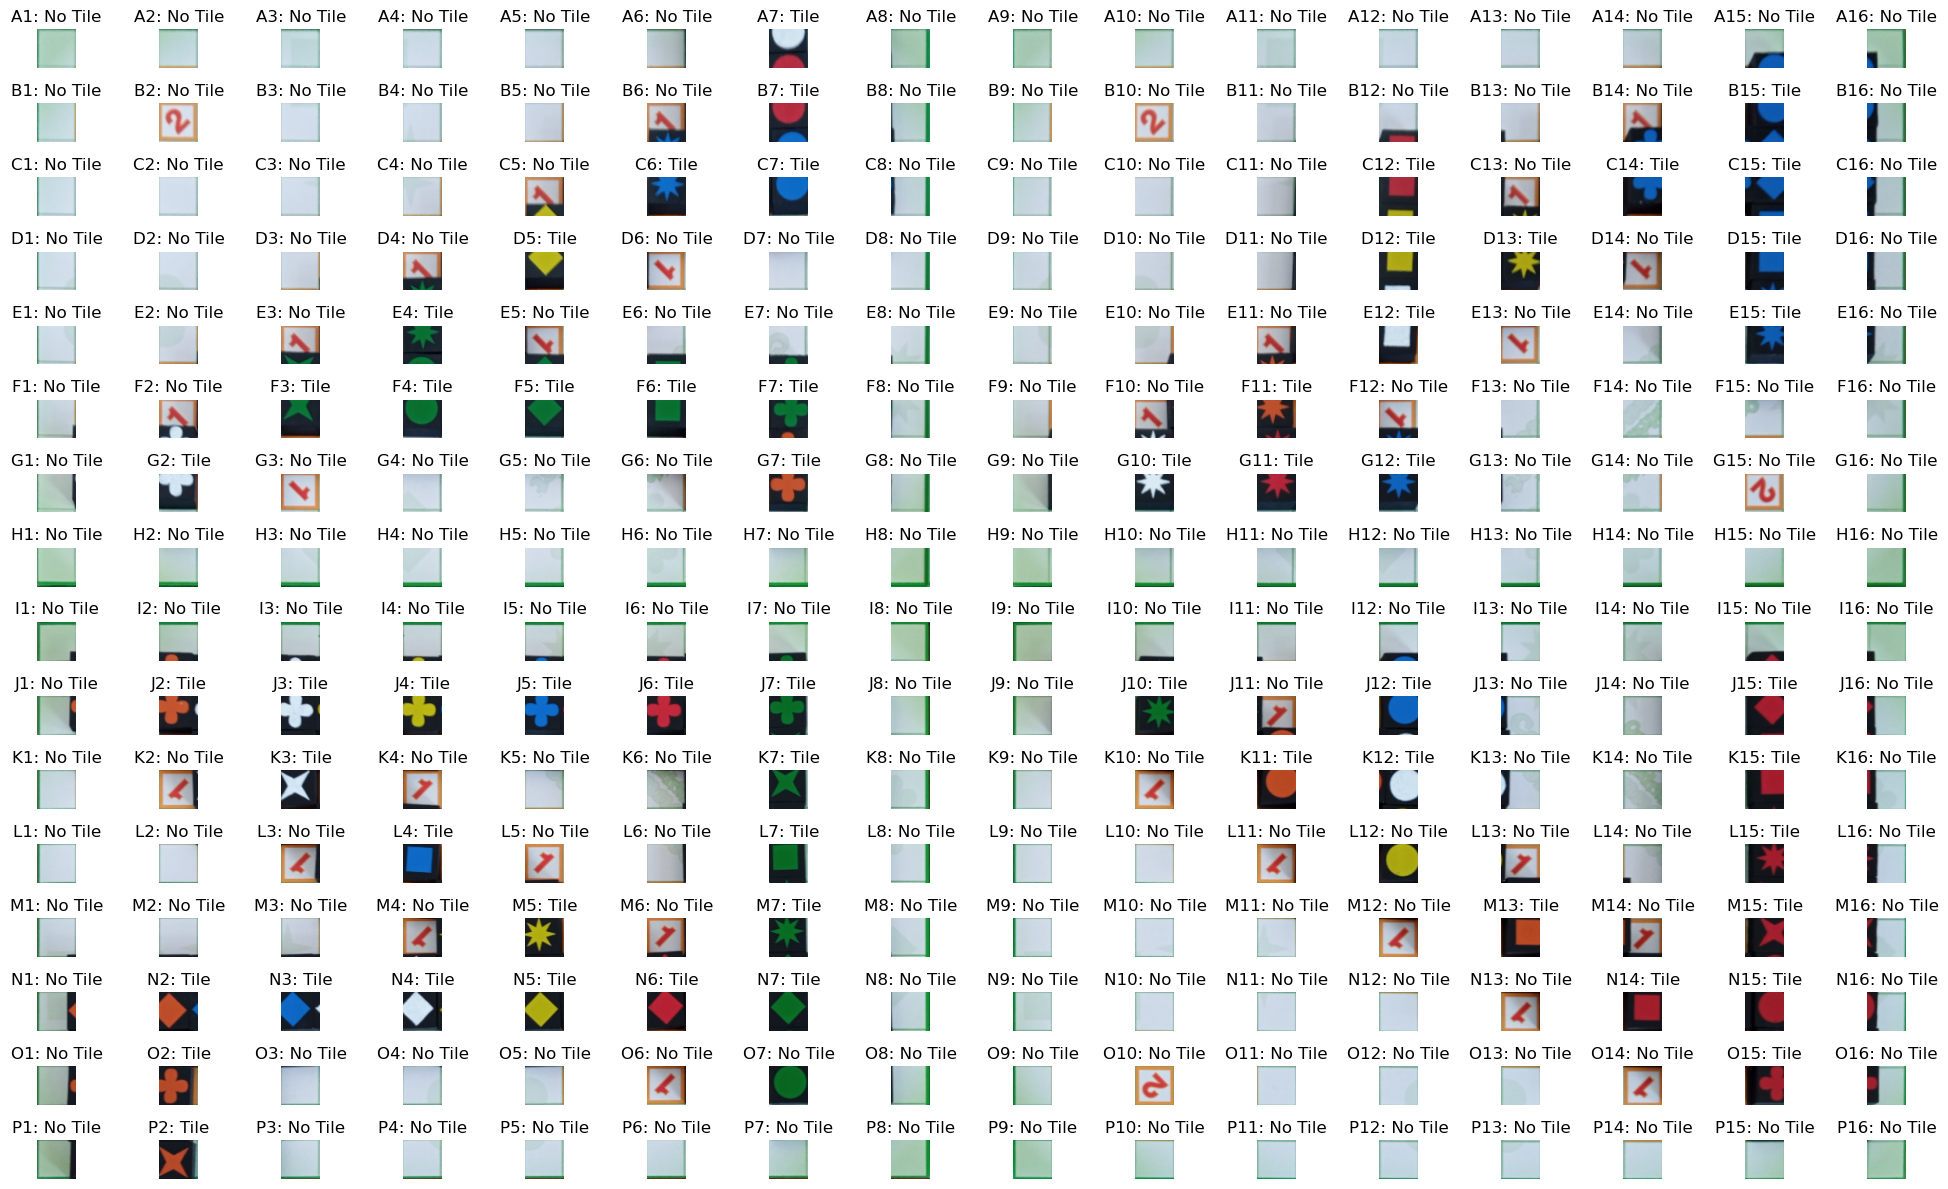

In [255]:
plt.figure(figsize=(20, 12))
for i, tile in enumerate(tiles, 1):
    label = tile['label']
    tile_present = tile['isPresent']
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
    plt.title(f"{label}: {'Tile' if tile_present else 'No Tile'}")
    plt.axis("off")
plt.tight_layout()

In [256]:
# %pip install torch
# %pip install torchvision

from DNN_shape_classifier import get_shape_model
import torch
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = get_shape_model(num_classes=10)
classifier.load_state_dict(torch.load("resnet_shape.pt", map_location=device))
classifier.to(device)
classifier.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
shape_names = ["0", "7", "8", "circle", "clover", "diamond", "square", "star4", "star8"]

tiles_classified = []

for tile in tiles_present:
    if not tile['isPresent']:
        continue

    label = tile['label']
    patch_img = tile['img']

    if patch_img is None or not isinstance(patch_img, np.ndarray):
        print(f"[WARN] Invalid image at {label}")
        continue

    try:
        # Convert OpenCV image to PIL
        img_pil = Image.fromarray(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
    except Exception as e:
        print(f"[ERROR] Failed to convert image at {label}: {e}")
        continue

    # Apply transform and predict
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = classifier(input_tensor)
        pred_idx = output.argmax(dim=1).item()
        shape = shape_names[pred_idx]

    print(f"Tile at {label}: {shape}")
    tiles_classified.append({'label': label, 'shape': shape, 'img': patch_img})
    

Tile at A7: diamond
Tile at B7: diamond
Tile at B15: star8
Tile at C6: star8
Tile at C7: diamond
Tile at C12: star4
Tile at C14: star8
Tile at C15: star8
Tile at D5: star8
Tile at D12: star8
Tile at D13: star8
Tile at D15: star8
Tile at E4: star8
Tile at E12: star8
Tile at E15: star8
Tile at F3: star4
Tile at F4: circle
Tile at F5: diamond
Tile at F6: star8
Tile at F7: diamond
Tile at F11: star8
Tile at G2: star4
Tile at G7: clover
Tile at G10: star8
Tile at G11: star8
Tile at G12: star8
Tile at J2: diamond
Tile at J3: star4
Tile at J4: star4
Tile at J5: diamond
Tile at J6: diamond
Tile at J7: clover
Tile at J10: star8
Tile at J12: diamond
Tile at J15: diamond
Tile at K3: star4
Tile at K7: star8
Tile at K11: diamond
Tile at K12: 0
Tile at K15: star8
Tile at L4: circle
Tile at L7: clover
Tile at L15: star8
Tile at M5: star8
Tile at M7: star8
Tile at M13: diamond
Tile at M15: star8
Tile at N2: diamond
Tile at N3: diamond
Tile at N4: star4
Tile at N5: diamond
Tile at N6: diamond
Tile at N

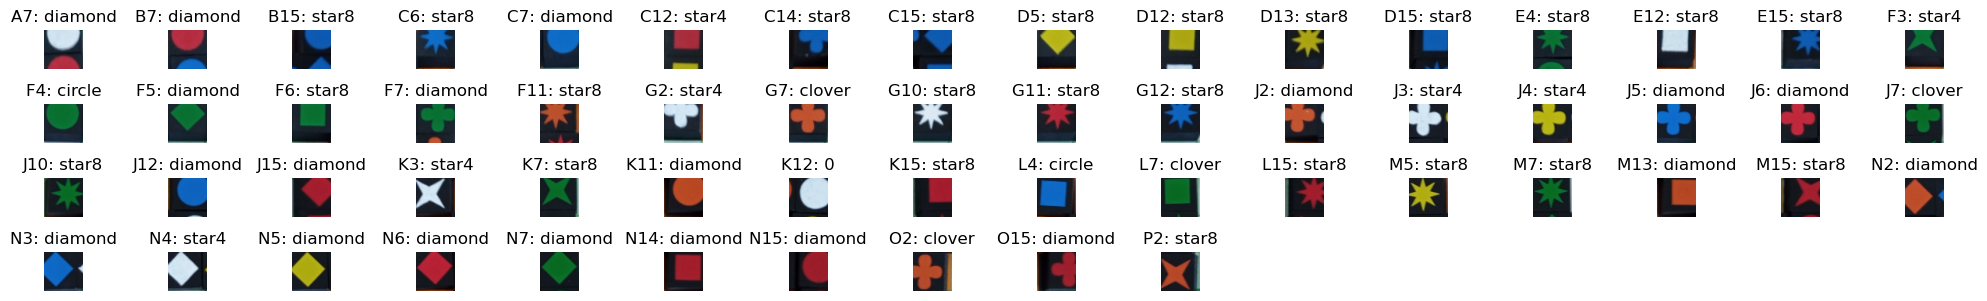

In [257]:
# plot images with preent tiles
plt.figure(figsize=(20, 12))
for i, tile in enumerate(tiles_classified, 1):
    label = tile['label']
    shape = tile['shape']
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
    plt.title(f"{label}: {shape}")
    plt.axis("off")
plt.tight_layout()

# # save tiles to tiles_dataset
# import os

# # Create a folder to save the tiles if it doesn't exist
# output_folder = "tiles_patches"
# os.makedirs(output_folder, exist_ok=True)

# # Iterate through the tiles_present list
# for tile in tiles_present:
#     label = tile['label']
#     tile_present = tile['isPresent']
#     if tile_present:  # Only save images where a tile is detected
#         # gray scale patches
#         # cells_grid[label] = cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2GRAY)
#         output_path = os.path.join(output_folder, f"{label}-4.jpg")
#         cv2.imwrite(output_path, cells_grid[label])  # Save the cell image

In [258]:
# Update tiles_present list with the classified shapes (remove shapes that are 0, 7, 8, 9)
tiles_present = [
	{**tile, 'shape': next((classified_tile['shape'] for classified_tile in tiles_classified if classified_tile['label'] == tile['label']), None)}
	for tile in tiles_present
	if next((classified_tile['shape'] for classified_tile in tiles_classified if classified_tile['label'] == tile['label']), None) not in ["0", "7", "8", "9"]
]

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter
import cv2
import numpy as np

def get_patch_colors(image, grid_size=(6, 6), debug=False):
    h, w = image.shape[:2]
    patch_h, patch_w = h // grid_size[1], w // grid_size[0]

    patch_colors = []

    for row in range(grid_size[1]):
        row_colors = []
        for col in range(grid_size[0]):
            x1 = col * patch_w
            y1 = row * patch_h
            patch = image[y1:y1+patch_h, x1:x1+patch_w]

            # Mask to ignore background (if needed, tweak thresholds)
            hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, (0, 50, 50), (180, 255, 255))  # non-background

            # Only consider masked pixels
            pixels = patch[mask > 0].reshape(-1, 3)
            if len(pixels) == 0:
                row_colors.append("empty")
                continue

            # Use KMeans to find the dominant color
            kmeans = KMeans(n_clusters=1, n_init='auto').fit(pixels)
            color = kmeans.cluster_centers_[0].astype(int)

            # Map to closest label
            label = map_color_to_name(color)
            row_colors.append(label)

            if debug:
                print(f"Patch ({row}, {col}) -> RGB: {color}, Label: {label}")

        patch_colors.append(row_colors)
    return patch_colors


In [ ]:
def map_color_to_name(color_bgr):
    # Simplified color label matching
    color_bgr = np.array(color_bgr)
    colors = {
        "red":     np.array([60, 60, 200]),
        "blue":    np.array([200, 60, 60]),
        "green":   np.array([60, 200, 60]),
        "yellow":  np.array([0, 220, 220]),
        "orange":  np.array([0, 140, 255]),
        # "purple":  np.array([150, 60, 150]),
        # "black":   np.array([0, 0, 0]),
        "white":   np.array([255, 255, 255]),
    }

    min_dist = float('inf')
    best_match = "unknown"
    for name, ref in colors.items():
        dist = np.linalg.norm(color_bgr - ref)
        if dist < min_dist:
            min_dist = dist
            best_match = name
    return best_match


In [259]:
def detect_tile_color(img_bgr):
    """
    Detect the dominant color of a tile using HSV color space.
    Assumes the input is a cropped tile patch.
    Returns one of: red, orange, yellow, green, blue, purple
    """

    # Resize to standard shape
    img = cv2.resize(img_bgr, (64, 64))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Crop to central region to avoid background borders
    center = hsv[16:48, 16:48]  # roughly center square

    # Calculate average hue, saturation, and value
    avg_hsv = np.mean(center.reshape(-1, 3), axis=0)
    hue, sat, val = avg_hsv

    # Classify by hue range
    if val > 170 and sat < 30:  # White has high value and low saturation
        return "white"
    elif hue < 15 or hue > 160:
        return "red"
    elif 15 <= hue < 20:
        return "orange"
    elif 20 <= hue < 35:
        return "yellow"
    elif 35 <= hue < 85:
        return "green"
    elif 85 <= hue < 135:
        return "blue"
    else:
        return "unknown"


In [263]:
tiles_full_classified = []
for tile in tiles_present:
    if not tile['isPresent']:
        continue

    img = tile['img']
    shape = next((t['shape'] for t in tiles_classified if t['label'] == tile['label']), None)
    if shape is None:
        print(f"[WARN] Shape not found for tile {tile['label']}")
        continue

    color = detect_tile_color(img)  # Ensure the function returns a single value
    print(f"{tile['label']}: {color}")
    tiles_full_classified.append({'label': tile['label'], 'shape': shape, 'color': color, 'img': img})

A7: blue
B7: unknown
B15: blue
C6: blue
C7: blue
C12: unknown
C14: blue
C15: blue
D5: green
D12: green
D13: green
D15: blue
E4: blue
E12: blue
E15: blue
F3: blue
F4: green
F5: green
F6: green
F7: green
F11: green
G2: blue
G7: yellow
G10: blue
G11: unknown
G12: blue
J2: green
J3: blue
J4: green
J5: blue
J6: red
J7: green
J10: green
J12: blue
J15: unknown
K3: blue
K7: green
K11: yellow
K15: unknown
L4: blue
L7: green
L15: unknown
M5: green
M7: green
M13: green
M15: unknown
N2: green
N3: blue
N4: blue
N5: yellow
N6: red
N7: green
N14: red
N15: red
O2: yellow
O15: unknown
P2: green


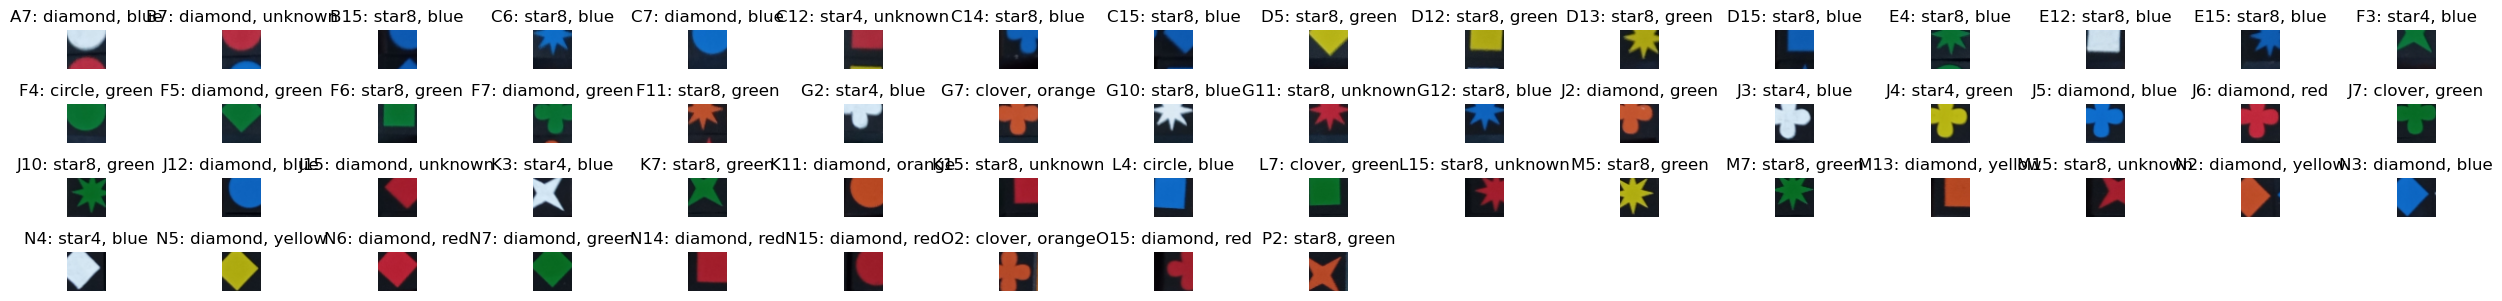

In [261]:
# plot pathces with tiles with both shape and color
plt.figure(figsize=(25, 12))
for i, tile in enumerate(tiles_full_classified, 1):
    label = tile['label']
    shape = tile['shape']
    color = tile['color']
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(detection_grid[label], cv2.COLOR_BGR2RGB))
    plt.title(f"{label}: {shape}, {color}")
    plt.axis("off")
plt.tight_layout()